# Learning the model

This shows a simplified example of learning the coefficients in the generator of the sparse noise model on a single qubit.

In [61]:
#helper libraries
import numpy as np
from random import random, choice
import math
from itertools import cycle
import scipy.optimize
import matplotlib.pyplot as plt

#qiskit functionalities
from qiskit import Aer, execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.visualization import plot_histogram

#noise model stuff
from qiskit.providers.aer.noise import NoiseModel, kraus_error, pauli_error
    
#operator info
from qiskit.quantum_info import PauliList, Pauli, Kraus, pauli_basis

plt.style.use("ggplot")

Define the terms
$$
\vec\lambda, \mathcal{F}, \mathcal{T}, \vec \omega
$$
Where $\vec \lambda$ is a list of the coefficients, $\mathcal{F}$ is the set of Pauli operators, $\mathcal{T}$ is the set of operators in the sparse model, and $\vec \omega$ is the transformed coefficients in the noise model (Eq. S9)

In [62]:
n = 1 #Number of qubits
T = PauliList(['I','X', 'Y', 'Z']) #List of Pauli operators
F = PauliList(['X', 'Y', 'Z']) #Pauli operators considered in the sparse model
coeffs = [random()*.1 for p in F] #lambda coefficients for the model Paulis

Eq. S9: 
$$
\omega_k = \frac{1}{2}(1+e^{-2\lambda_k})
$$

In [92]:
omegas = [.5*(1+np.exp(-2*lambdak)) for lambdak in coeffs]

Defining the simplectic inner product, a function such that
$$
\langle P_a, P_b \rangle_{sp} = 
\begin{cases}
0 & [P_a, P_b] = 0 \\
1 & \text{else}
\end{cases}
$$
This is expressed in a matrix $M(\mathcal{T}, \mathcal{F})_{ab} = \langle T_a, F_b \rangle_{sp}$ to simplify equation (S10)

In [93]:
def s_prod(a, b):
    return int(a.anticommutes(b))

M = [[s_prod(a,b) for b in F] for a in T]

ideal_fidelities is the ideal $\vec f$ (with components $f_a$) giving the fidelities for each element in $\mathcal{F}$. This is computed using Eq. (S11),
$$
-\log(\vec f)/2 = M\vec \lambda
$$

In [94]:
ideal_fidelities = np.exp(-2*np.dot(M, coeffs))
print(ideal_fidelities)

[1.         0.8133486  0.69805414 0.8412741 ]


The model fidelities can be converted to Pauli coefficients using the simplectic Hadamard transformation,
$$
c_b = \frac{1}{2^n} \sum_a (-1)^{\langle P_a, P_b\rangle_{sp}}f_a
$$
These convert the diagonal transfer matrix to a diagonal $\chi$ matrix.

In [95]:
#Do all 4^n-1 fidelities need to be measured or can some be omitted?
def WHtransform(P_b, eigenvals):
    return sum([(-1)**s_prod(P_a, P_b)*f_a/4**n for f_a, P_a in zip(eigenvals, T)])

chi = [WHtransform(b, ideal_fidelities) for b in T]
    
print(chi)

[0.8381692098638039, 0.06850508920708634, 0.01085785971033279, 0.08246784121877701]


Use the resulting diagonal process matrix to create a pauli channel
$$
\Lambda(\rho) = \sum_{i}\chi_i P_i \rho P_i
$$

In [67]:
#Pauli error channel
pauli_error_channel = pauli_error(zip(T, chi))
pauli_noise_model = NoiseModel()
pauli_noise_model.add_all_qubit_quantum_error(pauli_error_channel, ['id', 'x','y','z'])
pauli_basis_gates = pauli_noise_model.basis_gates

Following Flammia et Al., if $\ket{\pm}$ is an eigenstate of $P_a$ with eigenvalue $\pm 1$, then a pauli channel has the property that
$$
f_a = tr(P_a\Lambda(|\pm\rangle \langle \pm |) = \pm\frac{1}{2^n}tr(P_a \Lambda(P_a))
$$
This means that the fidelity $f_a$ can be measured by only preparing a single eigenstate of $P_a$.

In [96]:
backend = Aer.get_backend('qasm_simulator')

depths = [0,2,4,6,8,10] #number of folds to fit noise
circuits = {p:{d:[] for d in depths} for p in F}
samples = 100

for p in F:
    for depth in depths:
        for sample in range(samples):
            qc = QuantumCircuit(1,1)
            frame = Pauli("I") #store the overall pauli frame due to the twirl
            #prepare an eigenstate of the desired pauli operator
            match p.to_label():
                case "X":
                    qc.h(0)
                case "Y":
                    qc.h(0)
                    qc.s(0)

            #add twirling layers
            for j in range(depth-1):
                twirl = Pauli(choice("IXYZ"))
                qc.append(twirl,[0])
                frame = frame.compose(twirl) 

            #invert the overall effect of the twirl
            if depth > 0:
                qc.append(Pauli((frame.z, frame.x)), [0]) 

            #convert to computational basis
            match p.to_label():
                case "X":
                    qc.h(0)
                case "Y":
                    qc.sdg(0)
                    qc.h(0)

            #measure in the operator basis
            qc.measure(0,0)
        
            circuits[p][depth].append(qc)

Get measurements from noisy simulator

In [70]:
fidelities = {p:[] for p in F}
shots = 1000
for p in F:
    for d in depths:
        expectation = 0
        for circ in circuits[p][d]:
            #run circuit
            job = backend.run(circ,noise_model = pauli_noise_model, shots = shots)
            counts = job.result().get_counts()
            #compute expectation value of Z
            expectation += (1/shots)*(counts.get('0',0)*1+(-1)*counts.get('1',0))
        fidelities[p].append(expectation/samples)

The expectation value of any Pauli operator on a maximally randomized state is
$$
\begin{align*}
\frac{1}{2^n}\operatorname{Tr}[P_a\Lambda(I)] &= \frac{1}{2^n}\operatorname{Tr}[P_a \prod_{k}\omega_k I + (1-\omega_k)P_aIP_a] \\
&= \frac{1}{2^n}\operatorname{Tr}[P_a \prod_{k}\omega_k + (1-\omega_k)] \\
&= \frac{1}{2^n}\operatorname{Tr}[P_a] \\
&= 0
\end{align*}
$$
So we can assume that $f_a \to 0$ as the circuit depth grows to $\infty$. Due to SPAM, the fidelities at zero depth may be less than one. Errors accumulate exponentially, so the function chosen to fit is
$$
f_a(d) = c_1e^{-c_2d}
$$
Once the fit is obtained, $c_1$ is set to one to remove errors due to SPAM, because a SPAM-free situation would have $f_a=1$ at depth zero, and the noise channel fidelity $f_a$ is obtained by evaluating $e^{-c_2}$, corresponding to half a fold, or one gate application.

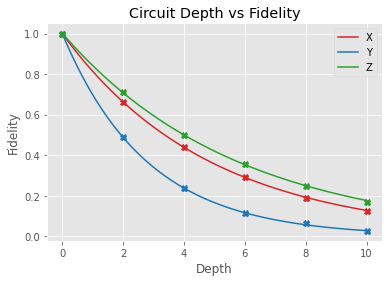

In [98]:
#plot each fold as two gates and scale so it starts at 2
xrange = np.linspace(0,np.max(depths),100) 
colcy = cycle(["tab:red", "tab:blue", "tab:green"])
expfit = lambda x,a,b: a* np.exp(-b*x)
measured_fidelities = []
#plot the measured fidelities vs gate depths
figs = []
for p in F:
    params, cv = scipy.optimize.curve_fit(expfit, depths, fidelities[p])
    measured_fidelities.append(np.exp(-params[1]))
    color = next(colcy)
    fig, = plt.plot(xrange, [expfit(x, *params) for x in xrange], color = color)
    figs.append(fig)
    plt.plot(depths, fidelities[p], color = color, linestyle = "None", marker = "X")
plt.title("Circuit Depth vs Fidelity")
plt.xlabel("Depth")
plt.ylabel("Fidelity")
plt.legend(figs, ["X","Y","Z"])

Comparing the extrapolated (measured) fidelities to the ideal ones

In [72]:
print("Measured fidelities: ", measured_fidelities)
print("Ideal Fidelitites: ", ideal_fidelities[1:])
print("Manhattan Norm: ", np.sum(np.abs(ideal_fidelities[1:]-measured_fidelities)))

Measured fidelities:  [0.8136761629428637, 0.6980195899691938, 0.8404387088145991]
Ideal Fidelitites:  [0.8133486  0.69805414 0.8412741 ]
Manhattan Norm:  0.0011975073307256556


The original fidelities are obtained from the model coefficients using Eq. S11
$$
-\frac{1}{2}\ln(\vec f) = M\vec \lambda
$$
Having measured $\vec f$, the solution $\vec \lambda$ is found such that
$$
\vert \vert M\lambda + \frac{1}{2}\ln(\vec f) \vert \vert_2
$$
is minimized

In [77]:
def lsq_fit(coeffs):
    return np.sum(np.square(np.dot(M,coeffs)+np.log(measured_fidelities)/2))

measured_coeffs, rnorm = scipy.optimize.nnls(M, -.5*np.log([1]+measured_fidelities))
#Compare guess to the actual values
print("Reconstructed model coefficients: ", measured_coeffs)
print("Ideal model coefficients: ", coeffs)

Reconstructed model coefficients:  [0.08178663 0.00512899 0.09796742]
Ideal model coefficients:  [0.08142522066508827, 0.004993653342113336, 0.09830408732389304]


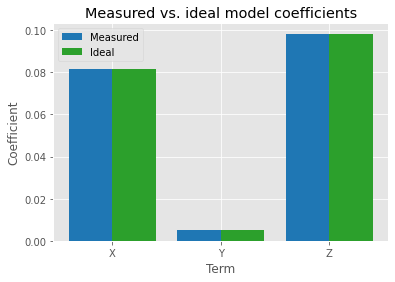

In [91]:
ax = np.arange(len(T)-1)
plt.bar(ax-.2,measured_coeffs,.4, color = "tab:blue")
plt.bar(ax+.2,coeffs,.4, color = "tab:green")
plt.xticks(ax, F)
plt.title("Measured vs. ideal model coefficients")
plt.ylabel("Coefficient")
plt.xlabel("Term")
plt.legend(["Measured", "Ideal"]);